In [17]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from joblib import dump, load
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import numpy as np
import itertools

In [2]:
#nltk.download()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\giova\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Testes com o dataset COVID19BR - Arquivos

In [2]:
def plota_matriz_de_confusao(cm,
                             target_names,
                             title='Confusion matrix',
                             cmap=None,
                             normalize=True):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()

## Documentação do método para apresentar, via gráfico, a matriz de confusão:    
### def plota_matriz_de_confusao(cm, target_names, title='Confusion matrix', cmap=None, normalize=True)
    
    Dada uma matriz de confusão (cm), mostra um gráfico:

    Arguments
    ---------
    cm:           matriz de confusão do sklearn.metrics.confusion_matrix

    target_names: dadas as classes tais [0,1,2], os nomes das classes[alto, médio, baixo]
    
    title:        título do gráfico

    cmap:         o gradiente dos valores exibidos como em matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    Se falso, imprime números inteiros
                  Se verdadeiro, imprime as proporções

    Exemplo de utilização:
    -----
    plota_matriz_de_confusao(cm           = cm,                  # Matriz de confusão criada
                                                                 # sklearn.metrics.confusion_matrix
                             normalize    = True,                # mostra proporções ou frações
                             target_names = y_labels_vals,       # lista dos nomes das classes
                             title        = nome do estimador)   # Título do gráfico

    Citação
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [3]:
stop_por = set(stopwords.words("portuguese"))
def limpa_texto(string):
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)    
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)  
    tx   = text.replace('&amp',' ')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stop_por]
    text = " ".join(text)
    return text

In [4]:
def imprime_metricas(pred,true):
    print(confusion_matrix(true,pred))
    print(classification_report(true,pred,))
    print("Acurácia : ",accuracy_score(pred,true))
    print("Precisão : ",precision_score(pred,true, average = 'weighted'))
    print("Recall   : ",recall_score(pred,true,  average = 'weighted'))
    print("F1       : ",f1_score(pred,true,  average = 'weighted'))

In [14]:
#
# Testes com o dataset COVID19BR
#
treino    = pd.read_csv('covidbr_labeled_train.csv')
validacao = pd.read_csv('covidbr_labeled_val.csv')
arquivo_total = pd.read_csv('covidbr_labeled.csv')

# Testes com dataset COVID19BR

In [15]:
treino['text'] = treino['text'].map(lambda x: limpa_texto(x))
"""
A linha 848 deste arquivo de treino estava vazia, 
ocasionando o  erro abaixo:
AttributeError: 'float' object has no attribute 'lower'
# como foi descoberta a linha com problema:
contador = 0
for i in treino['text']:
    contador = contador + 1
    limpa_texto(i)
print(contador)
"""
validacao['text'] = validacao['text'].map(lambda x: limpa_texto(x))    
arquivo_total['text'] = arquivo_total['text'].map(lambda x: limpa_texto(x))

# Testes com dataset COVID19BR - LinearSVC

SVM
valores:
[[547  61]
 [ 87 175]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       608
           1       0.74      0.67      0.70       262

    accuracy                           0.83       870
   macro avg       0.80      0.78      0.79       870
weighted avg       0.83      0.83      0.83       870

Acurácia :  0.8298850574712644
Precisão :  0.8368103852352651
Recall   :  0.8298850574712644
F1       :  0.8325452177971703


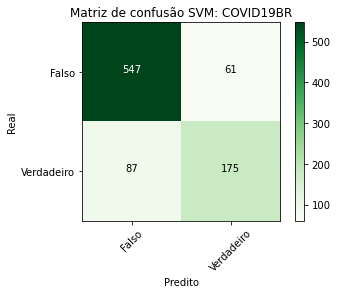

In [7]:
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', LinearSVC())
    ])
fit = pipeline.fit(treino['text'],treino['misinformation'])
print('SVM')
print ('valores:')
pred=pipeline.predict(validacao['text'])
imprime_metricas(pred,validacao['misinformation'])
plota_matriz_de_confusao(confusion_matrix(validacao['misinformation'],pred),
                         target_names=['Falso','Verdadeiro'], 
                         normalize = False, 
                         title = 'Matriz de confusão SVM: COVID19BR')

val_ori = pd.read_csv('covidbr_labeled_val.csv')
svm_val_misclass_df = val_ori[pred!=validacao['text']]

# Testes com o dataset COVID19BR - Logistic Regression

Logistic Regression
val:
[[578  30]
 [131 131]]
              precision    recall  f1-score   support

           0       0.82      0.95      0.88       608
           1       0.81      0.50      0.62       262

    accuracy                           0.81       870
   macro avg       0.81      0.73      0.75       870
weighted avg       0.81      0.81      0.80       870

Acurácia :  0.8149425287356322
Precisão :  0.8672602843315185
Recall   :  0.8149425287356322
F1       :  0.8299397009304305


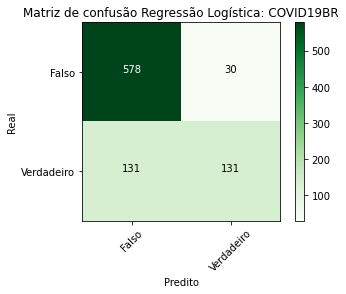

In [8]:
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', LogisticRegression())
    ])
fit = pipeline.fit(treino['text'],treino['misinformation'])
print('Logistic Regression')
print ('val:')
pred=pipeline.predict(validacao['text'])
imprime_metricas(pred,validacao['misinformation'])
plota_matriz_de_confusao(confusion_matrix(validacao['misinformation'],pred),
                         target_names=['Falso','Verdadeiro'], 
                         normalize = False,
                         title = 'Matriz de confusão Regressão Logística: COVID19BR')

# Testes com o dataset COVID19BR - GradientBoostingClassifier

Gradient Boost
val:
[[566  42]
 [121 141]]
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       608
           1       0.77      0.54      0.63       262

    accuracy                           0.81       870
   macro avg       0.80      0.73      0.75       870
weighted avg       0.81      0.81      0.80       870

Acurácia :  0.8126436781609195
Precisão :  0.8483074666463475
Recall   :  0.8126436781609195
F1       :  0.8235594536253196


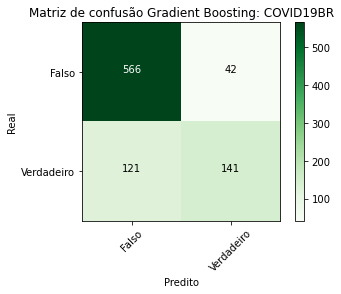

In [9]:
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', GradientBoostingClassifier())
    ])
fit = pipeline.fit(treino['text'],treino['misinformation'])
print('Gradient Boost')
print ('val:')
pred=pipeline.predict(validacao['text'])
imprime_metricas(pred,validacao['misinformation'])
plota_matriz_de_confusao(confusion_matrix(validacao['misinformation'],pred),
                         target_names=['Falso','Verdadeiro'], 
                         normalize = False,
                         title = 'Matriz de confusão Gradient Boosting: COVID19BR')

# Testes com o dataset COVID19BR - Árvore de decisão

Decision Tree
val:
[[498 110]
 [ 89 173]]
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       608
           1       0.61      0.66      0.63       262

    accuracy                           0.77       870
   macro avg       0.73      0.74      0.73       870
weighted avg       0.78      0.77      0.77       870

Acurácia :  0.771264367816092
Precisão :  0.7674319015160961
Recall   :  0.771264367816092
F1       :  0.768867345529569


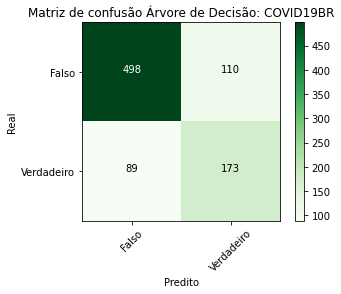

In [10]:
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', tree.DecisionTreeClassifier())
    ])
fit = pipeline.fit(treino['text'],treino['misinformation'])
print('Decision Tree')
print ('val:')
pred=pipeline.predict(validacao['text'])
imprime_metricas(pred,validacao['misinformation'])
plota_matriz_de_confusao(confusion_matrix(validacao['misinformation'],pred),
                         target_names=['Falso','Verdadeiro'], 
                         normalize = False,
                         title = 'Matriz de confusão Árvore de Decisão: COVID19BR')

# Testes com o dataset COVID19BR - Rede Neural MLP

Decision Tree
val:
[[527  81]
 [ 84 178]]
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       608
           1       0.69      0.68      0.68       262

    accuracy                           0.81       870
   macro avg       0.77      0.77      0.77       870
weighted avg       0.81      0.81      0.81       870

Acurácia :  0.8103448275862069
Precisão :  0.8109909896648704
Recall   :  0.8103448275862069
F1       :  0.8106574858733672


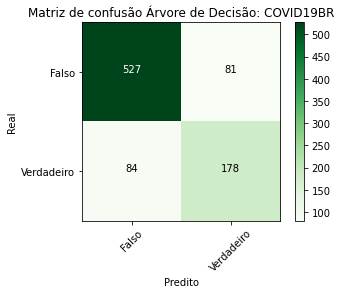

In [11]:
pipeline = Pipeline([
        ('bow', CountVectorizer()),  
        ('tfidf', TfidfTransformer()),  
        ('c', MLPClassifier())
    ])
fit = pipeline.fit(treino['text'],treino['misinformation'])
print('Decision Tree')
print ('val:')
pred=pipeline.predict(validacao['text'])
imprime_metricas(pred,validacao['misinformation'])
plota_matriz_de_confusao(confusion_matrix(validacao['misinformation'],pred),
                         target_names=['Falso','Verdadeiro'], 
                         normalize = False,
                         title = 'Matriz de confusão Árvore de Decisão: COVID19BR')

In [ ]:
svm_val_misclass_df.info()

In [ ]:
svm_val_misclass_df.to_excel('svm_val_misclassified.xlsx')

In [ ]:
svm_val_misclass_df.to_csv('svm_val_misclassified.csv')